# PREPARAÇÃO DOS DADOS 

# MODELO DE PREVISÃO DE CASOS DE DENGUE NO ESTADO DE MINAS GERAIS 

# ANO: 2022

## Clonando o repositório com os dados do problema

In [9]:
!rm -r IEC.PUC.Modelo.Notif.Dengue
!git clone https://github.com/cgalmeida/IEC.PUC.Modelo.Notif.Dengue.git

Cloning into 'IEC.PUC.Modelo.Notif.Dengue'...
remote: Enumerating objects: 865, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 865 (delta 25), reused 56 (delta 6), pack-reused 768
Receiving objects: 100% (865/865), 102.82 MiB | 23.91 MiB/s, done.
Resolving deltas: 100% (225/225), done.
Checking out files: 100% (567/567), done.


## Fazendo os imports das libs necessárias

In [3]:
import os
from io import StringIO
import codecs
import itertools
import numpy as np
import pandas as pd

## Especificando o caminho para os dados

In [4]:
path_data = os.path.join('IEC.PUC.Modelo.Notif.Dengue', 'dados')
path_data

'IEC.PUC.Modelo.Notif.Dengue/dados'

In [5]:
path_base = os.path.join('IEC.PUC.Modelo.Notif.Dengue', 'dados', 'metadados')
path_base

'IEC.PUC.Modelo.Notif.Dengue/dados/metadados'

In [10]:
path_data_proc = os.path.join('IEC.PUC.Modelo.Notif.Dengue', 'dados', 'processados')
path_data_proc

'IEC.PUC.Modelo.Notif.Dengue/dados/processados'

## Lendo os dados e armazenando em uma lista

In [7]:
def only_files(path):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield file

def break_test(s):
    return 'SINAN NET' not in s.upper()

def read_file(file_path, line_pos):
    fp = codecs.open(file_path, 'r', encoding='latin-1')
    txt_lines = fp.readlines()[line_pos:]
    md = [s for s in txt_lines]
    data_lines = list(itertools.takewhile(break_test, txt_lines))
    fp.close()
    return data_lines

def to_dataframe(lst):
    return pd.read_csv(StringIO(''.join(lst)), sep=';', encoding = "latin-1")

def create_col_year(df, filename_var):
    df = df.replace('-', '0')
    df['Ano'] = filename_var[-8:-4]
    return df.drop(columns=['Total'])

def read_folder(path_data, filename_var):
    files = list(only_files(path_data))
    files.sort()    
    return [create_col_year(to_dataframe(read_file(os.path.join(path_data, file_name), 3)), file_name) for file_name in files if filename_var in file_name]

def read_base(filename_var):
    file_path = os.path.join(path_base, filename_var) + '.csv'
    return pd.read_csv(file_path, sep=';', encoding = "ISO-8859-1")

def merge_base(df_data, df_base):
    df_data.columns.values[0] = 'Descricao'
    return pd.merge(df_data, df_base, on='Descricao', how='inner')

def transpose_data(df):
    # df.set_index(['descricao','Ano','codigo']).stack().reset_index()
    return df.melt(id_vars=['Descricao','Ano','Codigo']).rename(columns={'variable':'Mes', 'value': 'Casos'})

def format_res(df):
    df_mes = read_base('mes_abr').rename(columns={'Codigo': 'Codigo_Mes', 'Descricao': 'Mes'})
    df_mes = pd.merge(df, df_mes, on=['Mes'], how='inner')
    df_mes['Periodo'] = df_mes.apply(lambda x: x.Ano + '.' + str(x.Codigo_Mes).zfill(2), axis=1)
    return df_mes

def type_col(df):
    df['Descricao'] = df['Descricao'].astype('str')
    df['Ano'] = df['Ano'].astype('int64')
    df['Mes'] = df['Mes'].astype('str')
    df['Casos'] = df['Casos'].astype('int64')
    df['Periodo'] = df['Periodo'].astype('str')
    return df

def prepare_data(path_data, filename_var):
    df_base = read_base(filename_var)
    res = [merge_base(i, df_base) for i in read_folder(path_data, filename_var)]
    res = [format_res(transpose_data(df)) for df in res]    
    res = pd.concat(res[:], axis=0).reset_index(drop=True)
    res = type_col(res)
    res = res.groupby(['Ano', 'Codigo', 'Codigo_Mes', 'Periodo'], group_keys=False).sum().reset_index()
    return pd.merge(res, df_base, on=['Codigo'], how='inner')

def totalizar(df):
    return df.groupby(['Ano', 'Codigo_Mes', 'Periodo'], group_keys=False).sum().reset_index().drop(columns=['Codigo'])

In [11]:
names = ['classificacao', 'evolucao', 'faixa', 'macrorregiao']
for n in names:
    data_list = prepare_data(path_data, n)
    data_list.to_csv(os.path.join(path_data_proc, n + '.csv'), sep=';', encoding='latin-1')

In [12]:
%%time
filename_var = 'macrorregiao'
data_list = prepare_data(path_data, filename_var)
#data_list = data_list[data_list['MACRORREGIAO'] == 3101]
data_list = totalizar(data_list)
data_list.to_csv(os.path.join(path_data_proc, 'dengue_mg.csv'), sep=';', encoding='latin-1')
data_list.head()

CPU times: user 268 ms, sys: 3.79 ms, total: 272 ms
Wall time: 274 ms


,Ano,Codigo_Mes,Periodo,Casos
0,2007,1,2007.01,1625
1,2007,2,2007.02,3189
2,2007,3,2007.03,7899
3,2007,4,2007.04,8351
4,2007,5,2007.05,4547


## Dados pluviométricos

In [13]:
df_meteo = read_base('meteo_mg')
df_meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520 entries, 0 to 2519
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ANO               2520 non-null   int64  
 1   MES               2520 non-null   int64  
 2   MACRORREGIAO      2520 non-null   int64  
 3   PRECIPITACAO      2520 non-null   float64
 4   PRESSAO_ATM       2520 non-null   float64
 5   TEMPERATURA       2520 non-null   float64
 6   UMIDADE_RELATIVA  2520 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 137.9 KB


In [14]:
def crt_period(df):
    ano = '{0:0>4}'.format(df.ANO)
    mes = '{0:0>2}'.format(df.MES)
    return ano + '.' + mes
df_meteo['Periodo'] = df_meteo.apply(crt_period, axis=1)
df_meteo['Periodo'] = df_meteo.apply(crt_period, axis=1)
df_meteo.sample(5)

,ANO,MES,MACRORREGIAO,PRECIPITACAO,PRESSAO_ATM,TEMPERATURA,UMIDADE_RELATIVA,Periodo
388,2009,5,3107,0.021774,947.759005,19.545699,82.0,2009.05
110,2007,9,3109,0.003403,923.923652,23.843667,41.0,2007.09
1003,2013,1,3106,0.216331,984.965524,25.996808,71.0,2013.01
2004,2018,12,3113,0.324801,930.573822,24.697064,70.0,2018.12
2422,2021,6,3111,0.016067,972.220811,21.203033,73.0,2021.06


In [15]:
f = {'PRECIPITACAO':['sum'], 'PRESSAO_ATM':['mean'], 'TEMPERATURA':['mean'], 'UMIDADE_RELATIVA':['mean']}
df_meteo = df_meteo.groupby(['ANO', 'MES', 'Periodo'], group_keys=False).agg(f).reset_index()
df_meteo.columns = [i[0] for i in df_meteo.columns]
df_meteo.drop(columns=['ANO', 'MES'], inplace=True)

df_data = pd.merge(data_list, df_meteo, on='Periodo', how='inner')
df_data.drop(columns=['Ano', 'Codigo_Mes'], inplace=True)
df_data.to_csv(os.path.join(path_data_proc, 'dengue_meteo_mg.csv'), sep=';', encoding='latin-1')
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 179
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Periodo           180 non-null    object 
 1   Casos             180 non-null    int64  
 2   PRECIPITACAO      180 non-null    float64
 3   PRESSAO_ATM       180 non-null    float64
 4   TEMPERATURA       180 non-null    float64
 5   UMIDADE_RELATIVA  180 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 9.8+ KB


In [16]:
df_data.sample(5)

,Periodo,Casos,PRECIPITACAO,PRESSAO_ATM,TEMPERATURA,UMIDADE_RELATIVA
101,2015.06,17624,0.367516,936.199193,19.093917,74.571429
42,2010.07,1635,0.217148,937.070737,18.936782,69.000000
134,2018.03,4088,2.670312,929.685591,23.814061,76.214286
93,2014.10,706,1.359110,933.235596,23.078974,57.214286
5,2007.06,1059,0.107016,935.438935,18.737691,69.357143


## Dando uma olhada no dataset

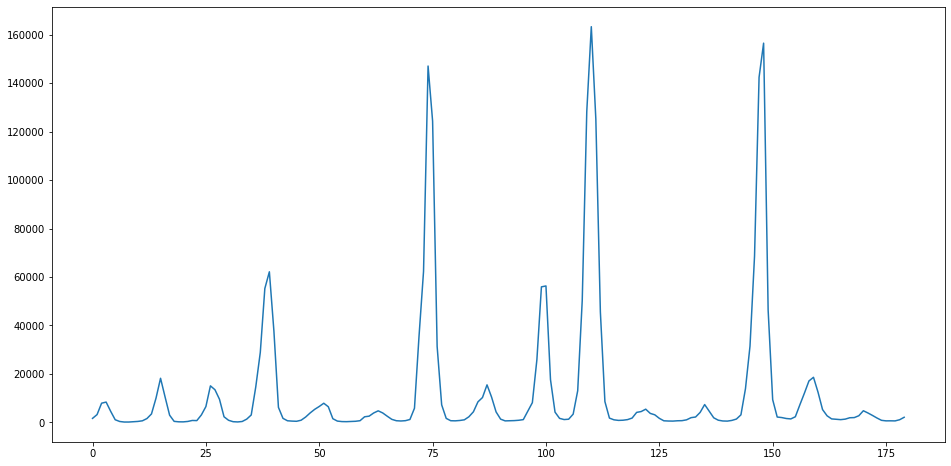

In [19]:
from matplotlib import pyplot as plt

%matplotlib inline

data = df_data.Casos.values.tolist()
plt.figure(figsize=(16,8))
plt.plot(data)
plt.show()